In [34]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(42)
import gc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from glob import glob

In [35]:
train_data = pd.read_csv('data/train_features.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test_data = pd.read_csv('data/test_features.csv')
sample = pd.read_csv('data/sample_submission.csv')

## Data Feature

데이터를 읽어보면, 데이터별로 ID값이 다양하게 존재합니다.

- train_data : x, y, z 좌표값 및 id, time 존재
- train_labels : id, labels, labels_desc
- test : train_data 와 동일

In [36]:
X_train = []

for uid in tqdm(train_data['id'].unique()):
    temp = np.array(train_data[train_data['id'] == uid].iloc[:, 2:], np.float32).T
    X_train.append(temp)
    
X_train = np.array(X_train, np.float32)
X_train_ori = X_train[:, :, :, np.newaxis]

X_test = []

for uid in tqdm(test_data['id'].unique()):
    temp = np.array(test_data[test_data['id'] == uid].iloc[:, 2:], np.float32).T
    X_test.append(temp)

X_test = np.array(X_test, np.float32)
X_test = X_test[:, :, :, np.newaxis]    

100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 2213.29it/s]


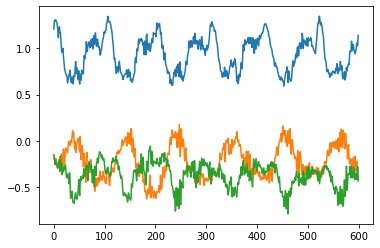

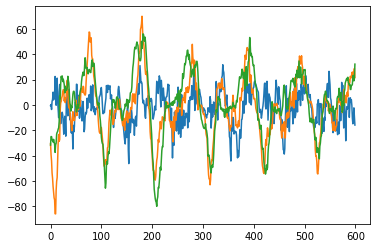

In [37]:
def vis(uid):
    plt.plot(X_train_ori[uid][0,:,0])
    plt.plot(X_train_ori[uid][1,:,0])
    plt.plot(X_train_ori[uid][2,:,0])
    plt.show()
    
    plt.plot(X_train_ori[uid][3,:,0])
    plt.plot(X_train_ori[uid][4,:,0])
    plt.plot(X_train_ori[uid][5,:,0])
    plt.show()

vis(0)

In [42]:
train_labels['start'] = 0
target_list = ['start', 'label']
train_labels = train_labels[target_list]
y_train_ori = np.array(train_labels, np.int32)
y_train_ori

array([[ 0, 37],
       [ 0, 26],
       [ 0,  3],
       ...,
       [ 0, 15],
       [ 0, 26],
       [ 0,  2]])

In [45]:
X_tr_data, X_val_data, Y_tr_data, Y_val_data = train_test_split(X_train_ori, y_train_ori, test_size = 0.1, random_state = 32)
print(len(X_tr_data), len(X_val_data), len(Y_tr_data), len(Y_val_data))

2812 313 2812 313


In [47]:
def map_func(x_train, y_train):
    x_train = random_shift(x_train)
    return x_train, y_train

def random_shift(data):
    shift = int(random.random()*600)
    data = np.roll(data, shift, axis = 1)
    return data

def shift(x, y):
    new = []
    for i in range(5):
        temp = np.roll(x, i*120, axis = 1)
        new.extend(temp)
    
    x = np.array(new)
    y = np.concatenate([y]*5)
    x, y = shuffle(x, y, random_state = 42)
    return x, y

shift(X_tr_data, Y_tr_data)[0].shape

(14060, 6, 600, 1)

In [48]:
BATCH_SIZE = 64
EPOCHS = 50
early_stopping = 10
num_layers = 1
dff = 512
num_heads = 1
dropout_rate = 0.2
d_model = 128
target_size = 61
base_channel = 16
k = 10
learning_rate = 0.00005

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_data, Y_tr_data))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_data, Y_val_data))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(X_val_data.shape[0])
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [52]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [53]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [54]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [55]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [56]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [57]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [58]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                                ])


In [59]:
class EncoderLayer(tf.keras.Model):
    def __init__(self, d_model, num_heads, dff, rate):
        super(EncoderLayer, self).__init__()
        
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        
        self.pos_encoding = positional_encoding(500, d_model)       
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x):        
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        
        attn, attn_weights_block = self.mha1(x, x, x, None)  # (batch_size, target_seq_len, d_model)
        attn = self.dropout1(attn)
        out = self.layernorm1(attn + x)
        
        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm2(ffn_output + out)
        
        return out

In [60]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate):
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.feature_extract_model = self.cnn_base(base_channel)
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        #self.pos_encoding = positional_encoding(114, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        
        #self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]

    def call(self, x, training):
        x = self.feature_extract_model(x)
        x = tf.keras.layers.Reshape((-1, x.shape[3]))(x)
        x = self.fc(x)
        seq_len = tf.shape(x)[1]
        #print(seq_len)
        #x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        #for i in range(self.num_layers):
        #    x = self.enc_layers[i](x)
        
        x = tf.keras.layers.Reshape((1, -1))(x)
        
        return x  # (batch_size, input_seq_len, d_model)
    
    def cnn_base(self, base_channel=8):
        input_layer = tf.keras.layers.Input(shape=(6, 600, 1))
        
        x = tf.keras.layers.Conv2D(base_channel*2, (1, 2), activation='relu', padding='same')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)
        
        x = tf.keras.layers.Conv2D(base_channel*4, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*8, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*16, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*32, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        output_layer = tf.keras.layers.Conv2D(base_channel*64, (1, 2), activation='relu', padding='same')(x)
        
        return tf.keras.models.Model(input_layer, output_layer)

In [61]:
sample_encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, rate=dropout_rate)
temp_input = next(iter(train_dataset))[0]

sample_encoder_output = sample_encoder(temp_input, False)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 1, 14592)


In [62]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3#, attn_weights_block1, attn_weights_block2

In [63]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            #attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x#, attention_weights

In [64]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_size=target_size,
                         maximum_position_encoding=500)
temp_input = next(iter(train_dataset))[1]#tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output = sample_decoder(temp_input, 
                        enc_output=sample_encoder_output, 
                        training=False,
                        look_ahead_mask=None, 
                        padding_mask=None)

output.shape#, attn['decoder_layer2_block2'].shape

TensorShape([64, 2, 512])

In [65]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_size, activation='softmax')

    def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_size)
        
        return final_output#, attention_weights

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [67]:
def loss_object(y, y_hat):
    y = tf.one_hot(tf.cast(y, tf.int32), target_size)
    return tf.keras.losses.categorical_crossentropy(y, y_hat, from_logits=False, label_smoothing = 0.0)

In [68]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, -1))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    real = tf.dtypes.cast(real, tf.int64)
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, -1))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [69]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          target_size, 
                          pe_target=target_size,
                          rate=dropout_rate)

In [70]:
def create_masks(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask

In [71]:
inp = next(iter(train_dataset))[0]
tar_inp = next(iter(train_dataset))[1][:,:-1]
combined_mask = create_masks(tar_inp)
transformer(inp, tar_inp, True, combined_mask, dec_padding_mask=None).shape

TensorShape([64, 1, 61])

In [72]:
!rm -r ./checkpoints

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [74]:
init_path = 'check'+"/checkpoints/init"

init_ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

init_ckpt_manager = tf.train.CheckpointManager(init_ckpt, init_path, max_to_keep=5)

init_ckpt_manager.save()

'check/checkpoints/init\\ckpt-1'

In [79]:
path = 'check'

In [75]:
@tf.function()
def train_step(inp, tar, training=True):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp,
                                  True,
                                  None,
                                  None)
        loss = loss_function(tar_real, predictions)
    if training==True:
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        train_accuracy(accuracy_function(tar_real, predictions))
    else:
        val_accuracy(accuracy_function(tar_real, predictions))
  
    return loss, predictions

In [76]:
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')
gc.collect()

2328

Init checkpoint restored!!


220it [00:13, 16.85it/s, Epoch=1, k=0, Loss=1.843855, Total Loss=2.182455, Accuracy=0.547]
5it [00:00,  7.97it/s, Epoch=1, k=0, Val Loss=1.927972, Val Total_Loss=1.705071, Val Accuracy=0.641]
220it [00:08, 25.24it/s, Epoch=2, k=0, Loss=1.512439, Total Loss=1.367814, Accuracy=0.665]
5it [00:00, 71.36it/s, Epoch=2, k=0, Val Loss=1.542438, Val Total_Loss=1.366861, Val Accuracy=0.677]
220it [00:08, 25.47it/s, Epoch=3, k=0, Loss=1.253057, Total Loss=1.086962, Accuracy=0.727]
5it [00:00, 72.40it/s, Epoch=3, k=0, Val Loss=1.216119, Val Total_Loss=1.106411, Val Accuracy=0.731]
220it [00:08, 25.65it/s, Epoch=4, k=0, Loss=1.090978, Total Loss=0.901149, Accuracy=0.768]
5it [00:00, 75.69it/s, Epoch=4, k=0, Val Loss=1.063656, Val Total_Loss=1.006670, Val Accuracy=0.76]
220it [00:08, 25.02it/s, Epoch=5, k=0, Loss=0.833796, Total Loss=0.773797, Accuracy=0.798]
5it [00:00, 75.69it/s, Epoch=5, k=0, Val Loss=0.880299, Val Total_Loss=0.875208, Val Accuracy=0.766]
220it [00:08, 24.64it/s, Epoch=6, k=0, Lo

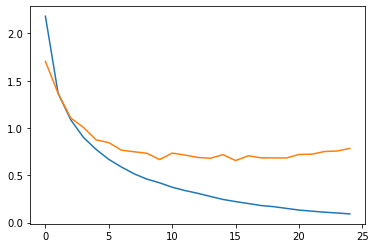

Init checkpoint restored!!


220it [00:08, 25.26it/s, Epoch=1, k=1, Loss=1.329834, Total Loss=2.190469, Accuracy=0.546]
5it [00:00, 70.36it/s, Epoch=1, k=1, Val Loss=1.444947, Val Total_Loss=1.580933, Val Accuracy=0.605]
220it [00:08, 24.94it/s, Epoch=2, k=1, Loss=1.052485, Total Loss=1.374563, Accuracy=0.671]
5it [00:00, 73.46it/s, Epoch=2, k=1, Val Loss=1.244864, Val Total_Loss=1.299437, Val Accuracy=0.668]
220it [00:08, 25.02it/s, Epoch=3, k=1, Loss=0.691085, Total Loss=1.088955, Accuracy=0.733]
5it [00:00, 75.69it/s, Epoch=3, k=1, Val Loss=1.187586, Val Total_Loss=1.117105, Val Accuracy=0.702]
220it [00:08, 25.32it/s, Epoch=4, k=1, Loss=0.602716, Total Loss=0.910082, Accuracy=0.772]
5it [00:00, 69.38it/s, Epoch=4, k=1, Val Loss=1.003563, Val Total_Loss=0.979246, Val Accuracy=0.745]
220it [00:08, 25.19it/s, Epoch=5, k=1, Loss=0.539481, Total Loss=0.780904, Accuracy=0.801]
5it [00:00, 75.69it/s, Epoch=5, k=1, Val Loss=0.934188, Val Total_Loss=0.890232, Val Accuracy=0.737]
220it [00:08, 24.96it/s, Epoch=6, k=1, L

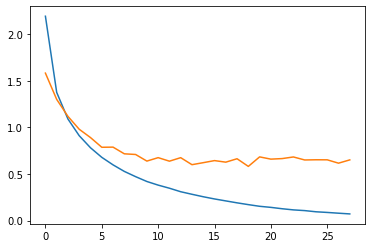

Init checkpoint restored!!


220it [00:08, 24.93it/s, Epoch=1, k=2, Loss=1.908056, Total Loss=2.190830, Accuracy=0.546]
5it [00:00, 67.51it/s, Epoch=1, k=2, Val Loss=1.445637, Val Total_Loss=1.679587, Val Accuracy=0.617]
220it [00:08, 24.86it/s, Epoch=2, k=2, Loss=1.446347, Total Loss=1.367451, Accuracy=0.671]
5it [00:00, 74.56it/s, Epoch=2, k=2, Val Loss=1.155213, Val Total_Loss=1.298997, Val Accuracy=0.647]
220it [00:08, 24.84it/s, Epoch=3, k=2, Loss=1.176710, Total Loss=1.086931, Accuracy=0.725]
5it [00:00, 69.36it/s, Epoch=3, k=2, Val Loss=1.008779, Val Total_Loss=1.149220, Val Accuracy=0.688]
220it [00:08, 24.85it/s, Epoch=4, k=2, Loss=0.968224, Total Loss=0.911207, Accuracy=0.768]
5it [00:00, 68.43it/s, Epoch=4, k=2, Val Loss=0.906831, Val Total_Loss=1.044272, Val Accuracy=0.736]
220it [00:08, 24.94it/s, Epoch=5, k=2, Loss=0.851294, Total Loss=0.789618, Accuracy=0.801]
5it [00:00, 75.69it/s, Epoch=5, k=2, Val Loss=0.743128, Val Total_Loss=0.910998, Val Accuracy=0.745]
220it [00:08, 25.10it/s, Epoch=6, k=2, L

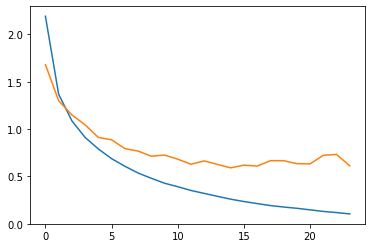

Init checkpoint restored!!


220it [00:08, 25.57it/s, Epoch=1, k=3, Loss=1.224783, Total Loss=2.176359, Accuracy=0.546]
5it [00:00, 74.56it/s, Epoch=1, k=3, Val Loss=1.835586, Val Total_Loss=1.623444, Val Accuracy=0.615]
220it [00:08, 25.45it/s, Epoch=2, k=3, Loss=0.864508, Total Loss=1.382314, Accuracy=0.665]
5it [00:00, 76.09it/s, Epoch=2, k=3, Val Loss=1.414166, Val Total_Loss=1.254329, Val Accuracy=0.667]
220it [00:08, 25.55it/s, Epoch=3, k=3, Loss=0.652056, Total Loss=1.095285, Accuracy=0.723]
5it [00:00, 74.56it/s, Epoch=3, k=3, Val Loss=1.185501, Val Total_Loss=1.078327, Val Accuracy=0.718]
220it [00:08, 25.37it/s, Epoch=4, k=3, Loss=0.577157, Total Loss=0.927922, Accuracy=0.762]
5it [00:00, 73.46it/s, Epoch=4, k=3, Val Loss=1.066325, Val Total_Loss=0.952493, Val Accuracy=0.751]
220it [00:08, 25.54it/s, Epoch=5, k=3, Loss=0.534754, Total Loss=0.783576, Accuracy=0.799]
5it [00:00, 74.56it/s, Epoch=5, k=3, Val Loss=0.890718, Val Total_Loss=0.834336, Val Accuracy=0.76]
220it [00:08, 25.61it/s, Epoch=6, k=3, Lo

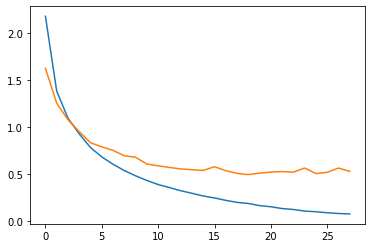

Init checkpoint restored!!


220it [00:08, 24.86it/s, Epoch=1, k=4, Loss=1.431999, Total Loss=2.250659, Accuracy=0.538]
5it [00:00, 78.05it/s, Epoch=1, k=4, Val Loss=1.456634, Val Total_Loss=1.599868, Val Accuracy=0.627]
220it [00:08, 25.38it/s, Epoch=2, k=4, Loss=1.197807, Total Loss=1.389346, Accuracy=0.662]
5it [00:00, 81.89it/s, Epoch=2, k=4, Val Loss=0.981899, Val Total_Loss=1.224748, Val Accuracy=0.721]
220it [00:08, 24.79it/s, Epoch=3, k=4, Loss=1.039990, Total Loss=1.109236, Accuracy=0.719]
5it [00:00, 75.69it/s, Epoch=3, k=4, Val Loss=0.911228, Val Total_Loss=1.057640, Val Accuracy=0.742]
220it [00:08, 26.04it/s, Epoch=4, k=4, Loss=0.801522, Total Loss=0.920319, Accuracy=0.76] 
5it [00:00, 78.05it/s, Epoch=4, k=4, Val Loss=0.739682, Val Total_Loss=0.903417, Val Accuracy=0.768]
220it [00:08, 26.74it/s, Epoch=5, k=4, Loss=0.613351, Total Loss=0.789892, Accuracy=0.791]
5it [00:00, 76.85it/s, Epoch=5, k=4, Val Loss=0.769737, Val Total_Loss=0.868012, Val Accuracy=0.786]
220it [00:08, 25.34it/s, Epoch=6, k=4, L

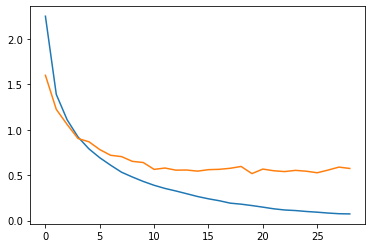

Init checkpoint restored!!


220it [00:09, 24.09it/s, Epoch=1, k=5, Loss=1.289419, Total Loss=2.206254, Accuracy=0.543]
5it [00:00, 13.54it/s, Epoch=1, k=5, Val Loss=1.529382, Val Total_Loss=1.663315, Val Accuracy=0.65]
220it [00:08, 26.13it/s, Epoch=2, k=5, Loss=0.889729, Total Loss=1.370313, Accuracy=0.666]
5it [00:00, 75.69it/s, Epoch=2, k=5, Val Loss=1.177419, Val Total_Loss=1.355815, Val Accuracy=0.68]
220it [00:08, 25.98it/s, Epoch=3, k=5, Loss=0.664940, Total Loss=1.086067, Accuracy=0.725]
5it [00:00, 73.46it/s, Epoch=3, k=5, Val Loss=0.947135, Val Total_Loss=1.180225, Val Accuracy=0.704]
220it [00:08, 26.24it/s, Epoch=4, k=5, Loss=0.496201, Total Loss=0.902425, Accuracy=0.766]
5it [00:00, 79.29it/s, Epoch=4, k=5, Val Loss=0.884624, Val Total_Loss=1.079995, Val Accuracy=0.741]
220it [00:08, 26.34it/s, Epoch=5, k=5, Loss=0.533832, Total Loss=0.769800, Accuracy=0.799]
5it [00:00, 78.05it/s, Epoch=5, k=5, Val Loss=0.759031, Val Total_Loss=0.966749, Val Accuracy=0.751]
220it [00:08, 26.37it/s, Epoch=6, k=5, Los

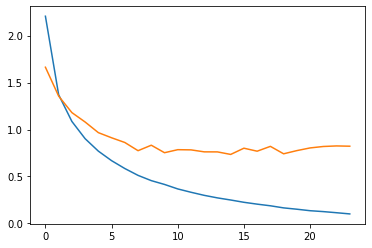

Init checkpoint restored!!


220it [00:08, 26.30it/s, Epoch=1, k=6, Loss=1.829248, Total Loss=2.202343, Accuracy=0.544]
5it [00:00, 78.06it/s, Epoch=1, k=6, Val Loss=1.586115, Val Total_Loss=1.590945, Val Accuracy=0.631]
220it [00:08, 25.50it/s, Epoch=2, k=6, Loss=1.544659, Total Loss=1.373134, Accuracy=0.667]
5it [00:00, 80.57it/s, Epoch=2, k=6, Val Loss=1.265678, Val Total_Loss=1.324341, Val Accuracy=0.687]
220it [00:08, 25.15it/s, Epoch=3, k=6, Loss=1.385913, Total Loss=1.095562, Accuracy=0.727]
5it [00:00, 73.46it/s, Epoch=3, k=6, Val Loss=1.236427, Val Total_Loss=1.148470, Val Accuracy=0.705]
220it [00:08, 24.61it/s, Epoch=4, k=6, Loss=1.299820, Total Loss=0.916604, Accuracy=0.766]
5it [00:00, 73.46it/s, Epoch=4, k=6, Val Loss=1.187882, Val Total_Loss=1.011240, Val Accuracy=0.756]
220it [00:08, 25.23it/s, Epoch=5, k=6, Loss=1.069810, Total Loss=0.777343, Accuracy=0.801]
5it [00:00, 61.67it/s, Epoch=5, k=6, Val Loss=1.034346, Val Total_Loss=0.928852, Val Accuracy=0.754]
220it [00:08, 25.50it/s, Epoch=6, k=6, L

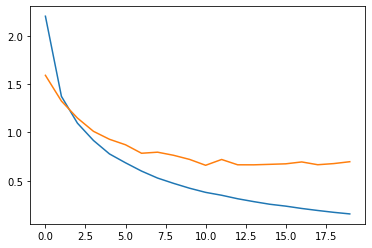

Init checkpoint restored!!


220it [00:08, 25.65it/s, Epoch=1, k=7, Loss=1.672050, Total Loss=2.210849, Accuracy=0.543]
5it [00:00, 59.47it/s, Epoch=1, k=7, Val Loss=1.381884, Val Total_Loss=1.653265, Val Accuracy=0.608]
220it [00:08, 25.58it/s, Epoch=2, k=7, Loss=1.178449, Total Loss=1.374809, Accuracy=0.671]
5it [00:00, 73.46it/s, Epoch=2, k=7, Val Loss=1.039810, Val Total_Loss=1.339899, Val Accuracy=0.681]
220it [00:08, 25.56it/s, Epoch=3, k=7, Loss=1.107693, Total Loss=1.095404, Accuracy=0.726]
5it [00:00, 74.56it/s, Epoch=3, k=7, Val Loss=0.972214, Val Total_Loss=1.204679, Val Accuracy=0.713]
220it [00:08, 25.61it/s, Epoch=4, k=7, Loss=0.653362, Total Loss=0.919906, Accuracy=0.763]
5it [00:00, 72.40it/s, Epoch=4, k=7, Val Loss=0.859149, Val Total_Loss=1.055712, Val Accuracy=0.743]
220it [00:08, 25.44it/s, Epoch=5, k=7, Loss=0.649293, Total Loss=0.783068, Accuracy=0.798]
5it [00:00, 75.69it/s, Epoch=5, k=7, Val Loss=0.763257, Val Total_Loss=0.939441, Val Accuracy=0.729]
220it [00:08, 25.61it/s, Epoch=6, k=7, L

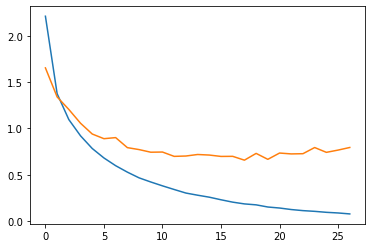

Init checkpoint restored!!


220it [00:08, 25.57it/s, Epoch=1, k=8, Loss=1.109909, Total Loss=2.228814, Accuracy=0.541]
5it [00:00, 75.69it/s, Epoch=1, k=8, Val Loss=1.482059, Val Total_Loss=1.587572, Val Accuracy=0.626]
220it [00:08, 25.55it/s, Epoch=2, k=8, Loss=0.806464, Total Loss=1.372021, Accuracy=0.666]
5it [00:00, 73.46it/s, Epoch=2, k=8, Val Loss=1.066554, Val Total_Loss=1.264647, Val Accuracy=0.677]
220it [00:08, 25.58it/s, Epoch=3, k=8, Loss=0.604922, Total Loss=1.080375, Accuracy=0.729]
5it [00:00, 74.56it/s, Epoch=3, k=8, Val Loss=0.970783, Val Total_Loss=1.098068, Val Accuracy=0.746]
220it [00:08, 25.58it/s, Epoch=4, k=8, Loss=0.595989, Total Loss=0.898902, Accuracy=0.768]
5it [00:00, 73.46it/s, Epoch=4, k=8, Val Loss=0.886115, Val Total_Loss=0.972582, Val Accuracy=0.764]
220it [00:08, 25.64it/s, Epoch=5, k=8, Loss=0.464845, Total Loss=0.776088, Accuracy=0.796]
5it [00:00, 73.46it/s, Epoch=5, k=8, Val Loss=0.850216, Val Total_Loss=0.931211, Val Accuracy=0.767]
220it [00:08, 25.63it/s, Epoch=6, k=8, L

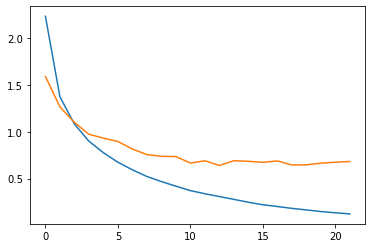

Init checkpoint restored!!


220it [00:08, 25.65it/s, Epoch=1, k=9, Loss=1.371220, Total Loss=2.241104, Accuracy=0.539]
5it [00:00, 75.69it/s, Epoch=1, k=9, Val Loss=1.523843, Val Total_Loss=1.555444, Val Accuracy=0.622]
220it [00:08, 25.56it/s, Epoch=2, k=9, Loss=1.097491, Total Loss=1.397065, Accuracy=0.664]
5it [00:00, 75.69it/s, Epoch=2, k=9, Val Loss=1.277692, Val Total_Loss=1.224616, Val Accuracy=0.685]
220it [00:08, 25.69it/s, Epoch=3, k=9, Loss=0.859929, Total Loss=1.115441, Accuracy=0.718]
5it [00:00, 74.56it/s, Epoch=3, k=9, Val Loss=1.054530, Val Total_Loss=1.013820, Val Accuracy=0.738]
220it [00:08, 25.73it/s, Epoch=4, k=9, Loss=0.761456, Total Loss=0.928930, Accuracy=0.763]
5it [00:00, 74.56it/s, Epoch=4, k=9, Val Loss=1.006989, Val Total_Loss=0.923375, Val Accuracy=0.766]
220it [00:08, 25.66it/s, Epoch=5, k=9, Loss=0.755884, Total Loss=0.798335, Accuracy=0.791]
5it [00:00, 73.46it/s, Epoch=5, k=9, Val Loss=0.835884, Val Total_Loss=0.779085, Val Accuracy=0.805]
220it [00:08, 25.70it/s, Epoch=6, k=9, L

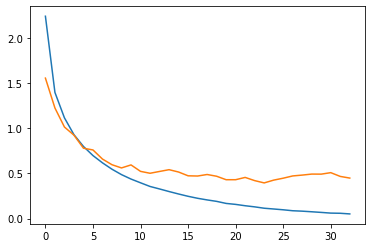

In [80]:
k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(k_fold.split(X_train_ori, y_train_ori[:,1])):
    x_train, y_train = X_train_ori[train_idx], y_train_ori[train_idx]
    x_val, y_val = X_train_ori[val_idx], y_train_ori[val_idx]    
    
    x_train, y_train = shift(x_train, y_train)
    #x_val, y_val = shift(x_val, y_val)
    x_train, y_train = shuffle(x_train, y_train)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    if init_ckpt_manager.latest_checkpoint:
        init_ckpt.restore(init_ckpt_manager.latest_checkpoint)
        print ('Init checkpoint restored!!')
    
    checkpoint_path = path+f"/checkpoints/model_{i}"

    ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    loss_plot, val_loss_plot = [], []
    for epoch in range(EPOCHS):
        total_loss, total_val_loss = 0, 0
        train_accuracy.reset_states()
            
        tqdm_dataset = tqdm(enumerate(train_dataset))
        
        for (batch, (tensor, target)) in tqdm_dataset:
            
            batch_loss, pred_list = train_step(tensor, target, training=True)
            total_loss += batch_loss
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Loss': '{:06f}'.format(batch_loss.numpy()),
                'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
                'Accuracy':train_accuracy.result().numpy(), 
            })
            if batch % 30 == 0:
                gc.collect()

        loss_plot.append(total_loss / (batch+1))
        
        val_accuracy.reset_states()
        
        tqdm_dataset_val = tqdm(enumerate(val_dataset))

        for (batch, (tensor, target)) in tqdm_dataset_val:

            batch_val_loss, pred_list = train_step(tensor, target, training=False)
            total_val_loss += batch_val_loss
            
            tqdm_dataset_val.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Val Loss': '{:06f}'.format(batch_val_loss.numpy()),
                'Val Total_Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                'Val Accuracy':val_accuracy.result().numpy(), 
            })
            
        val_loss_plot.append(total_val_loss / (batch+1))
        
        if np.min(val_loss_plot) == val_loss_plot[-1]:
            ckpt_manager.save()
        
        if epoch >= early_stopping and np.min(val_loss_plot[-early_stopping:]) == val_loss_plot[-early_stopping]:
            break
    
    plt.plot(loss_plot)
    plt.plot(val_loss_plot)
    plt.show()

In [81]:
@tf.function
def evaluate(tensor):
    decoder_input = [0] * tensor.shape[0]
    output = tf.expand_dims(decoder_input,1)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(tensor,
                              output,
                              False,
                              None,
                              None)
    
    # select the last word from the seq_len dimension
    proba = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    
    predicted_id = tf.cast(tf.argmax(proba, axis=-1), tf.int32)
    
    output = tf.concat([output, predicted_id], axis=-1)

    return output, proba

In [82]:
def test_map_func(data):
    data = np.roll(data, j*10, axis=1)
    return data

In [84]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test))
test_dataset = test_dataset.map(lambda item1: tf.numpy_function(test_map_func, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [85]:
preds = []

for i in range(k):
    checkpoint_path = path+f"/checkpoints/model_{i}"
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
    
    for j in tqdm(range(60)):
        pred = []
        for batch in iter(test_dataset):
            output, proba = evaluate(batch[0])
            proba = proba.numpy()[:,0,:]
            pred.extend(proba)
        pred = np.array(pred)
        preds.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  8.89it/s]


In [87]:
sample_submission = pd.read_csv('data/sample_submission.csv')
pred = np.mean(preds, axis=0)
sample_submission.iloc[:,1:] = pred
sample_submission.to_csv(path+'/submission.csv', index=False)
sample_submission.to_csv('./submission.csv', index=False)